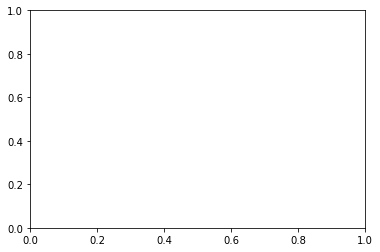

In [1]:
%matplotlib inline
import os
import sys
from os import path, listdir
from collections import namedtuple

import pickle
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Use simpson's rule for calculating AUC
from scipy.integrate import simpson

from process_results import recursive_file_search

# plt.rcParams['figure.constrained_layout.use'] = True
# plt.xlim(xmin=0.0)

RESULTS_DIR = path.abspath("../results")

def label_bars(bars, ax, customtxt = "", orientation="v"):
    for bar in bars:
        if customtxt:
            txt = customtxt
        else:
            if orientation == "v":
                txt = bar.get_height()
                xy=(bar.get_x() + bar.get_width() / 2, txt)
                xytxt = (0,1)
                va="bottom"
                ha="center"
            else:
                txt = bar.get_width()
                xy=(txt, bar.get_y() + bar.get_height() / 2)
                xytxt = (1,0)
                va = "center"
                ha = "left"
                
        max_chars = 6
            
        ax.annotate(f"{txt}"[:max_chars], 
                   xy=xy,
                   xytext=xytxt,
                   textcoords="offset points",
                   ha=ha, va=va)
        
def my_bar_plot(ax, values, groups, ylabel, datalabel, title="my bar plot", orientation="v"):
    bar_width = 0.4
    
    # Set all labels
    x_pos = np.arange(len(groups))
    
    if orientation == "v":
        bartype = "bar"
    else:
        bartype = "barh"

    barcall = getattr(ax, bartype)

    if len(values) == 2 and len(datalabel) == 2:
        my_bar = []
        my_bar.append(barcall(x_pos - bar_width/2, values[0], bar_width, label=datalabel[0]))
        my_bar.append(barcall(x_pos + bar_width/2, values[1], bar_width, label=datalabel[1]))
    else:
        my_bar = barcall(x_pos, values, bar_width, label=datalabel)
    

    if orientation == "v":
        ax.set_ylabel(ylabel)
        ax.set_xticks(x_pos)
        ax.set_xticklabels(groups)
    else:
        ax.set_xlabel(ylabel)
        ax.set_yticks(x_pos)
        ax.set_yticklabels(groups)
    ax.legend()
    ax.set_title(title)

    if isinstance(my_bar, list):
        for bar in my_bar:
            label_bars(bar, ax, orientation=orientation)
    else:
        label_bars(my_bar, ax, orientation=orientation)

    return my_bar

def save_my_figure(fig, figtype: str, machine: str, workload: str):
    figure_loc = path.join(path.dirname(path.realpath(sys.argv[1])), machine, workload)

    os.makedirs(figure_loc, exist_ok=True)
    
    figure_loc = path.join(figure_loc, figtype) + ".png"
    
    
    fig.savefig(figure_loc, bbox_inches="tight")
    

    

In [2]:
# Find all results
result_filter = lambda x: "processed-" in x
prediction_filter = lambda x: "predictions-" in x

all_results = list(recursive_file_search(RESULTS_DIR, result_filter))
all_predictions = list(recursive_file_search(RESULTS_DIR, prediction_filter))

result_prefix = path.commonprefix(all_results)

# Find all c5n directories
c5n_filter = lambda x: "c5n" in x
c5n_results = list(filter(c5n_filter, all_results))


c5n_results = list(map(lambda x: path.split(x), c5n_results))
all_results = list(map(lambda x: path.split(x), all_results))

c5n_per_workload = dict()

machine_workload_sched = dict()

for (p, result) in all_results:
    workload = result.replace("processed-results-", "").replace(".txt", "")
    
    sched = p.replace(result_prefix, "")
    sched_machine = sched.split("/")[0]
    sched = "".join([c for c in sched_machine if c.isupper()]) 
    machine = sched_machine.replace(sched, "")
    
    if machine == "":
        machine = "m510"
    
    sysmon = path.join(p, f"sysmon-{workload}.txt")
    # check for a sysmon file
    if not path.exists(sysmon):
        sysmon = None
    else:
        sysmon = pd.read_csv(sysmon, comment="#", skipinitialspace=True)
    
    if machine not in machine_workload_sched:
        machine_workload_sched[machine] = dict()
    
    if workload not in machine_workload_sched[machine]:
        machine_workload_sched[machine][workload] = {"results": [], "predictions": dict()}
    # Already storing the dataframes
    machine_workload_sched[machine][workload]["results"].append((sched, pd.read_csv(path.join(p, result), comment="#", skipinitialspace=True), sysmon))
    
    try:
        # In a try-block, as a StopIteration is raised when no next found
        prediction = next( (p for p in all_predictions 
                            if p == path.join(result_prefix, sched_machine, f"predictions-{workload}.txt")
                            ) , [None])
    except:
        prediction = None
        
    machine_workload_sched[machine][workload]["predictions"][sched] = prediction

# machine_workload_sched["c5n"]["poisson-12500-1hr-mem"]

# nice snippet from stackoverflow
def sizeof_fmt(num, suffix='B'):
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f%s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f%s%s" % (num, 'Yi', suffix)


from sys import getsizeof
sizeof_fmt(getsizeof(pickle.dumps(machine_workload_sched)))


'95.3MiB'

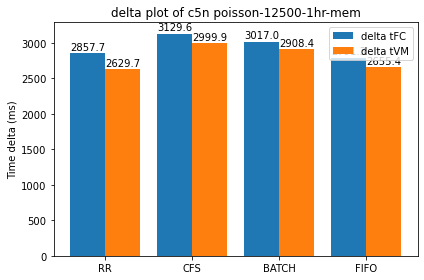

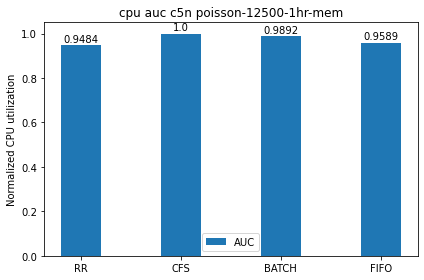

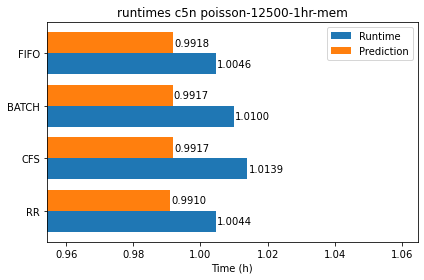

In [3]:
all_figs = []
all_axes = []

for machine in machine_workload_sched:
    # Skip others for now
    if machine != "c5n" and machine != "apollo":
        continue
        
    cur_axes = []
    cur_figs = []
    
    for workload in machine_workload_sched[machine]:
        # Skip others for now
        if workload != "poisson-12500-1hr-mem":
            continue

        # lists for gathering the data
        deltavm = []
        deltafc = []
        auc_sys = []
        
        # store the auc's of total sys cpu time and user cpu time
        cpu_sys_user = []
        runtimes = []

        bar_width = 0.4

        for result in machine_workload_sched[machine][workload]["results"]:
            # collect some basic metrics
            deltavm.append((result[0], result[1]["d tVM"].mean()))
            deltafc.append((result[0], result[1]["d tFC"].mean()))
            runtimes.append([result[0], result[1]["end time"].max()])
            
            # sysmon is not always present
            if result[2] is not None:
                # Normalize the sysmon times
                result[2]["t"] = result[2]["t"] - result[2]["t"].min()
                
                # Use a tuple here, as sysmon readings are optional
                # so we must know whether the result+sched has a sysmon
                auc_sys.append((result[0], simpson(result[2]["cpu_percentage"], result[2]["t"])))
                cpu_sys_user.append((result[0], simpson(result[2]["cpu_system"]), simpson(result[2]["cpu_user"])))
#             else:
#                 auc_sys.append((result[0], "None"))
#                 cpu_sys_user.append(())
                
                
        #Create figures
        deltafig, deltaax = plt.subplots()
        cur_axes.append(deltaax)
        cur_figs.append(("time-delta", deltafig))
        
        my_bar_plot(deltaax, [ [x[1] for x in deltafc], [y[1] for y in deltavm] ], 
                    [s[0] for s in deltafc], "Time delta (ms)", ["delta tFC", "delta tVM"],
                    f"delta plot of {machine} {workload}")
        
        # Set all for the sysmon plot (not always present)
        if auc_sys:
            sysfig, sysax = plt.subplots()
            cur_axes.append(sysax)
            cur_figs.append(("AUC", sysfig))

            # Normalize the values
            y_values = [val[1] for val in auc_sys]
            y_max = max(y_values)

            my_bar_plot(sysax, [ y/y_max for y in y_values ],
                        [s[0] for s in auc_sys], "Normalized CPU utilization",
                        "AUC", f"cpu auc {machine} {workload}")
        
        # Create the bars with runtimes
        runfig, runax = plt.subplots()
        cur_figs.append(("runtime", runfig))
        cur_axes.append(runax)
        
        # collect predicted runtimes
        for i, lst in enumerate(runtimes):
            pred = pd.read_csv(machine_workload_sched[machine][workload]["predictions"][lst[0]], comment="#", skipinitialspace=True)
            
            pred_runtime = pred["pred. end time"].max()
            runtimes[i].append(pred_runtime)
            
        tmp = [runtime for _, runtime, _ in runtimes]
        shortest_runtime = min(tmp)/3600000.0
        longest_runtime = max(tmp)/3600000.0
        del tmp
        
              
        my_bar_plot(runax, [ [x[1]/3600000.0 for x in runtimes], [y[2]/3600000.0 for y in runtimes] ],
                    [s[0] for s in runtimes], "Time (h)", ["Runtime", "Prediction"],
                    f"runtimes {machine} {workload}", "h")
        
        runax.set_xlim(xmin=shortest_runtime*0.95)

        # Create the table with cpu ratio's
#         tablefig, tableax = plt.subplots()
#         cur_figs.append(tablefig)
#         cur_axes.append(tableax)
        
#         cols = ["Ratio"]
#         rows = [x[0] for x in cpu_sys_user]
#         cell = [[f"{round((x[2]/x[1]), 3)}"] for x in cpu_sys_user]
        
#         print(cpu_sys_user)
#         tableax.axis("off")
#         tableax.table(cellText=cell, rowLabels=rows, colLabels=cols, loc="top")

        cells = [["Scheduler", "Ratio"] ]
        cells = cells + [ [x[0], f"{round((x[2]/x[1]), 3)}"] for x in cpu_sys_user]
        
        
        for ax in cur_axes:
#             ax.margins(0.1)
            ax.autoscale_view()
            
        for figtype, fig in cur_figs:
            fig.tight_layout()
#             save_my_figure(fig, figtype, machine, workload)
#             plt.close(fig=fig)
        
        
        
    all_axes = all_axes + cur_axes
    all_figs = all_figs + [f[1] for f in cur_figs]
    
